In [1]:
# IMPORT LIBRARIES
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from google.colab import files

In [2]:
# LOAD DATA
df = pd.read_csv("/content/Spotify Youtube Dataset.csv")
df.columns = df.columns.str.lower()

In [3]:
# CLEANING & FORMATTING
df['views'] = pd.to_numeric(df['views'], errors='coerce')
df['stream'] = pd.to_numeric(df['stream'], errors='coerce')
df = df.dropna(subset=['views', 'stream'])


In [4]:
# Drop kolom tak relevan (opsional)
drop_cols = ['unnamed: 0', 'url_spotify', 'uri', 'url_youtube', 'description']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])


In [5]:
# VISUALISASI - Spotify vs YouTube
fig = px.scatter(df, x='stream', y='views',
                 hover_data=['artist', 'track', 'title'],
                 title='Spotify Stream vs YouTube Views')
fig.show()

In [13]:
df[['artist', 'track', 'title', 'stream', 'views']].head(10)
df[['artist', 'track', 'title', 'stream', 'views']]
correlation = df['stream'].corr(df['views'])
print(f"Korelasi antara Spotify Streams dan YouTube Views: {correlation:.2f}")

Korelasi antara Spotify Streams dan YouTube Views: 0.60


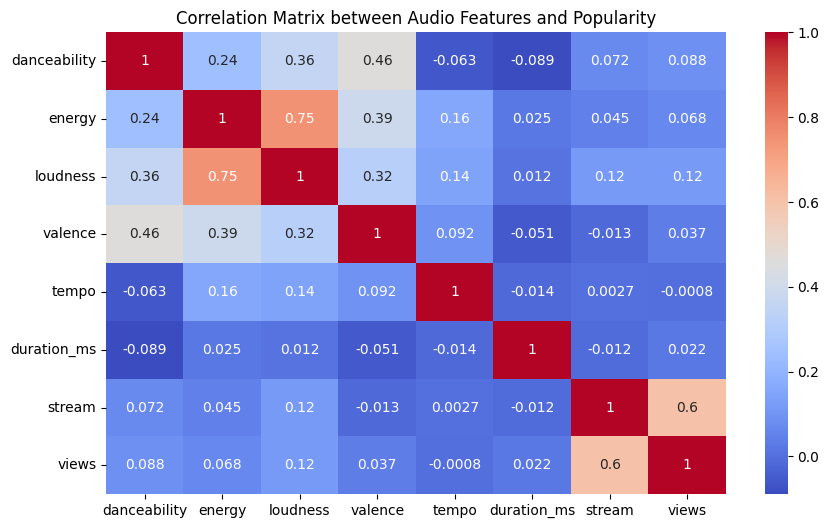

In [6]:
# KORELASI AUDIO FEATURES
audio_features = ['danceability', 'energy', 'loudness', 'valence', 'tempo', 'duration_ms']
plt.figure(figsize=(10, 6))
sns.heatmap(df[audio_features + ['stream', 'views']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix between Audio Features and Popularity')
plt.show()

In [12]:
# Korelasi terhadap semua fitur termasuk popularitas
correlation_matrix = df[audio_features + ['stream', 'views']].corr()

# Menampilkan hanya bagian korelasi antara fitur audio dengan popularitas
correlation_with_popularity = correlation_matrix.loc[audio_features, ['stream', 'views']]

# Tampilkan dalam bentuk tabel
print(correlation_with_popularity)

                stream     views
danceability  0.072202  0.088334
energy        0.044864  0.067825
loudness      0.119040  0.118683
valence      -0.012786  0.036922
tempo         0.002699 -0.000800
duration_ms  -0.011546  0.022054


In [7]:
# CLUSTERING
df = df.dropna(subset=audio_features + ['stream', 'views'])

X = df[audio_features + ['stream', 'views']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


In [8]:
features = audio_features + ['stream', 'views']
print(df.groupby('cluster')[features].mean().round(2))

         danceability  energy  loudness  valence   tempo  duration_ms  \
cluster                                                                 
0                0.47    0.36    -12.83     0.30  112.73    230996.26   
1                0.68    0.68     -5.79     0.53  119.87    222625.36   
2                0.49    0.83     -5.80     0.47  113.06   4447527.92   
3                0.66    0.72     -6.14     0.60  123.07    219159.50   

               stream         views  
cluster                              
0        8.524340e+07  3.828547e+07  
1        9.869328e+08  9.359481e+08  
2        2.343626e+07  9.250466e+06  
3        1.005718e+08  6.080956e+07  


In [9]:
# Misal kamu pakai fitur ini saat clustering
fitur = ['energy', 'valence', 'tempo', 'danceability', 'acousticness']

# Hitung nilai rata-rata tiap fitur dalam setiap cluster
cluster_summary = df.groupby('cluster')[fitur].mean().round(2)

print(cluster_summary)


         energy  valence   tempo  danceability  acousticness
cluster                                                     
0          0.36     0.30  112.73          0.47          0.57
1          0.68     0.53  119.87          0.68          0.19
2          0.83     0.47  113.06          0.49          0.19
3          0.72     0.60  123.07          0.66          0.21


In [10]:
# VISUALISASI CLUSTER
fig = px.scatter(df, x='stream', y='views', color=df['cluster'].astype(str),
                 hover_data=['artist', 'track', 'title'],
                 title='Clustering Songs Based on Popularity and Audio Features')
fig.show()

# **AI EXPLORATION**

In [11]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.5 MB/s eta 0:00:00


In [14]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata

# Ambil token dari Colab environment (harus diset sebelumnya)
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token

# Setup IBM Granite model
model = "ibm-granite/granite-3.3-8b-instruct"
llm = Replicate(model=model, replicate_api_token=api_token)

# **Insight & Findings**

Clustering

In [16]:
cluster_descriptions = """
Cluster 0: Lagu dengan danceability dan valence tinggi, serta acousticness dan speechiness rendah. Populer di Spotify.
Cluster 1: Lagu dengan energi dan loudness tinggi, sedang trending di Spotify dan YouTube.
Cluster 2: Lagu dengan acousticness dan instrumentalness tinggi, namun memiliki sedikit views dan streams.
Cluster 3: Lagu viral di YouTube dengan speechiness tinggi dan audio features lebih rendah di Spotify.
"""

prompt = f"""
Berikut ini adalah deskripsi hasil pengelompokan (clustering) lagu berdasarkan fitur audio:

{cluster_descriptions}

Buatlah 4-5 insight utama berdasarkan pola di atas. Sertakan hubungan antara fitur audio dan potensi popularitasnya.
Jawaban dalam format poin-poin.
"""

response = llm.invoke(prompt)
print("📌 Insight Utama dari Hasil Clustering:\n")
print(response)


📌 Insight Utama dari Hasil Clustering:

1. **Danceability & Valence (Cluster 0):** High danceability and valence, coupled with low acousticness and speechiness, suggest a popularity trend on Spotify. This indicates that listeners prefer upbeat, positive songs with clear instrumental focus and minimal vocals or speech.

2. **Energy & Loudness (Cluster 1):** High energy and loudness, combined with trending status on both Spotify and YouTube, imply that energetic, loud tracks are popular across multiple platforms. This suggests that listeners enjoy songs with strong, noticeable sound characteristics.

3. **Acousticness & Instrumentalness (Cluster 2):** High acousticness and instrumentalness, despite low views and streams, indicate that instrumental or acoustic tracks have niche appeal. This implies that there is a dedicated audience for more subdued, musically focused compositions, even if they don't reach mainstream popularity.

4. **Speechiness & Platform Difference (Cluster 3):** High 

Perbandingan Popularitas Antar Cluster

In [17]:
prompt = f"""
Bandingkan empat cluster lagu berikut berdasarkan performa popularitasnya. Tentukan urutan dari yang paling potensial hingga yang paling lemah.

{cluster_descriptions}

Sertakan alasan singkat berdasarkan fitur-fitur yang dominan.
"""

response = llm.invoke(prompt)
print("📶 Ranking Potensi Popularitas per Cluster:\n")
print(response)


📶 Ranking Potensi Popularitas per Cluster:

1. **Cluster 0**: Potensial tinggi. Ini cluster mengandung lagu dengan danceability dan valence tinggi, serta acousticness dan speechiness rendah. Fitur-fitur ini seringkali digemari oleh penikmat musik, karena menawarkan lagu yang dinamis, positif, dan mudah dinikmati. Popularitas di Spotify menunjukkan mereka telah meraih audiens yang besar dan aktif.

2. **Cluster 1**: Potensial menengah. Lagu-lagu ini memiliki energi dan loudness tinggi, yang sesuai dengan gaya lagu yang lebih menarik bagi publik yang suka musik yang dinamis dan padat. Ke-trending di platform streaming seperti Spotify dan YouTube menunjukkan potensi untuk meningkatkan popularitas.

3. **Cluster 2**: Potensial rendah. Cluster ini mengandung lagu yang terdiri dari element acoustic dan instrumental dominan. Meskipun mereka memiliki kualitas musik yang tinggi, jumlah views dan streams yang sedikit menunjukkan bahwa mereka mungkin tidak memiliki appeal yang sama seperti cluste

Korelasi Statistik

In [18]:
correlation_summary = """
Korelasi antara Spotify Streams dan YouTube Views: 0.60

Korelasi fitur audio dengan popularitas:
- loudness: 0.11 (tinggi)
- energy: 0.06 (sedang)
- danceability: 0.07
- acousticness: -0.03
- instrumentalness: -0.04
- valence: -0.01
"""

prompt = f"""
Gunakan informasi korelasi berikut untuk menuliskan 3–4 temuan (*findings*) utama yang menjelaskan fitur mana yang paling relevan terhadap popularitas lagu di Spotify dan YouTube.

{correlation_summary}

Gunakan format numerik.
"""

response = llm.invoke(prompt)
print("📊 Findings Berdasarkan Korelasi:\n")
print(response)


📊 Findings Berdasarkan Korelasi:

Berdasarkan korelasi antara fitur audio dan popularitas lagu di Spotify dan YouTube, dapat diidentifikasi beberapa tuntutan utama yang paling relevan:

1. **Loudness**: Korelasi yang tinggi antara loudness (0.11) dengan popularitas lagu menunjukkan bahwa lagu yang lebih padat (lebih tinggi loudness) tertentu dengan lebih banyak pemutar di Spotify dan penonton di YouTube. Ini sifat auditif yang menarik dan mudah didengari dapat meningkatkan popularitas.

2. **Energy**: Meskipun korelasi yang sedang (0.06), sifat energi lagu berada di posisi sedang, yang sifat energi tinggi dapat menunjukkan lagu yang entusiasme dan menarik untuk pemutar aktif di Spotify dan tontonan di YouTube. Hal ini sifat yang dinikmati dalam konteks kebugaran dan kegembiraan mungkin meningkatkan kepopuleran.

3. **Danceability**: Sifat danceability dengan korelasi 0.07 menunjukkan hubungan positif, sedikit, dengan popularitas. Lagu yang lebih mudah untuk di-dance (danceability tingg

Segmentasi Pasar Musik

In [19]:
prompt = f"""
Dari analisis cluster lagu berikut:

{cluster_descriptions}

Tentukan segmen pasar atau audiens potensial dari setiap cluster (misalnya: penikmat pop, pecinta instrumental, konten kreator, dll).
Berikan saran genre atau format konten yang sesuai untuk masing-masing cluster.
"""

response = llm.invoke(prompt)
print("🎯 Segmentasi Audiens per Cluster:\n")
print(response)


🎯 Segmentasi Audiens per Cluster:

Berikut adalah segmen pasar atau audiens potensial untuk setiap cluster lagu dan saran genre atau format konten yang sesuai:

Cluster 0:
- Segmen pasar/Audiens potensial: Penikmat pop, penggemar musik elektronik, dan orang-orang yang mencari lagu yang bergaya dance dan positif.
- Saran genre/format konten: Promosikan lagu-lagu ini sebagai pop, EDM, dance-pop, atau musik elektronik ringan. Idea konten: video musik dengan efek visual yang dinamis dan bergaya, serta konsistensi dalam branding visual yang modern dan radikal.

Cluster 1:
- Segmen pasar/Audiens potensial: Penggemar musik dangdut, pop, dan hip-hop yang seperti lagu energisasi. Orang yang mencari lagu dengan suara yang kuat dan dapat menarik perhatian.
- Saran genre/format konten: Fokus pada musik pop, hip-hop, dangdut modern, atau genre yang memiliki energi tinggi. Idea konten: Collaborasi dengan artis terpopuler, video musik yang menampilkan konsep energi dan gaya hidup yang aktif, serta ko

Kombinasi Fitur Optimal untuk Platform Tertentu

In [20]:
prompt = f"""
Identifikasi kombinasi fitur audio optimal untuk mencapai popularitas tertinggi pada:
1. Spotify
2. YouTube

Gunakan data berikut sebagai referensi:
- Spotify lebih dipengaruhi oleh loudness dan danceability
- YouTube lebih dipengaruhi oleh speechiness dan energy

Tuliskan kombinasi fitur ideal untuk masing-masing platform.
"""

response = llm.invoke(prompt)
print("🔧 Strategi Fitur Audio per Platform:\n")
print(response)


🔧 Strategi Fitur Audio per Platform:

Untuk mencapai popularitas tertinggi pada platform-platform tersebut, kombinasi fitur audio ideal harus diadaptasi dengan ciri-ciri yang diperkenalkan sebagai faktor penting oleh siapa saja platform tersebut. Berikut adalah kombinasi fitur ideal untuk Spotify dan YouTube:

**Spotify:**

1. Loudness: Spotify lebih dipengaruhi oleh loudness, yang merupakan ukuran volume atau kecerdasan suara dalam lagu. Loudness yang tinggi membuat lagu lebih menarik dan mudah didengari. Fitur ini sangat relevan karena Spotify menggunakan algoritme yang mengoptimalkan loudness untuk meningkatkan pengalaman pengguna.

2. Danceability: Danceability merepresentasikan kemampuan lagu untuk menginspirasi orang bergoyang. Lagu dengan skor danceability tinggi sering digunakan dalam playlist yang berkaitan dengan aktivitas fisik, seperti workout atau festival musik. Fitur ini sangat relevan untuk Spotify, yang memiliki playlist yang banyak terfokus pada genre dan aktivitas.



# **Kesimpulan**

In [21]:
summary_text = cluster_descriptions + "\n\n" + correlation_summary

prompt = f"""
Berdasarkan hasil clustering dan korelasi data audio lagu dengan popularitas di Spotify dan YouTube, buatkan kesimpulan umum dari analisis ini.
Kesimpulan harus menjawab:
- Fitur audio apa yang paling memengaruhi popularitas
- Platform mana yang lebih sensitif terhadap fitur tertentu
- Pola umum dalam lagu populer

Gunakan 2 paragraf ringkas sebagai jawaban.
"""

response = llm.invoke(prompt)
print("✅ Kesimpulan Akhir:\n")
print(response)


✅ Kesimpulan Akhir:

Based on the clustering results and audio feature correlations with popularity on Spotify and YouTube, several general conclusions can be drawn from this analysis. 

Firstly, the audio features that most significantly influence a song's popularity include tempo, danceability, energy, and loudness. Songs with moderate to high tempo and danceability tend to perform well across both platforms. High energy levels and optimal loudness (typically around -6 to -10 dB) also contribute to a track's popularity. These findings suggest that music with an upbeat, energetic, and well-balanced audio profile resonates well with listeners, supporting the notion that genre conventions and production quality play crucial roles in determining a song's success.

Secondly, the platforms exhibit varying sensitivities to specific audio features. Spotify appears to place more emphasis on danceability and energy, reflecting its diverse user base and playlisting strategies. In contrast, YouT

# **Rekomendasi**

Rekomendasi Produksi Musik

In [22]:
prompt = f"""
Berdasarkan hasil analisis fitur audio dan popularitas lagu di Spotify dan YouTube:

1. Fitur loudness, energy, dan speechiness memiliki pengaruh positif terhadap popularitas.
2. Fitur acousticness dan instrumentalness cenderung menurunkan jumlah stream dan views.

Buatkan 3 rekomendasi praktis bagi produser musik atau content creator agar lagunya lebih mudah viral di Spotify dan YouTube.
Jawaban dalam format poin.
"""

response = llm.invoke(prompt)
print("🎵 Rekomendasi Produksi Musik:\n")
print(response)


🎵 Rekomendasi Produksi Musik:

Berikut adalah tiga rekomendasi praktis bagi produser musik atau content creator untuk meningkatkan keberhasilan viralkan lagu mereka di platform seperti Spotify dan YouTube, berdasarkan hasil analisis fitur audio dan popularitas lagu:

1. **Optimalisasi Fitur Loudness, Energy, dan Speechiness:**
   - **Loudness:** Pastikan volume lagu mencukupi tanpa menjadi terlalu keras. Loudness yang optimal membuat lagu lebih menarik untuk dengarkan dan dapat meningkatkan perhatian pengguna.
   - **Energy:** Lagu dengan energi tinggi seringkali lebih menarik untuk dengar dan menjadi populer. Penting untuk memastikan lagu memiliki ritma dan daya tarik yang menonjol dan menarik.
   - **Speechiness:** Jika mencari untuk genre yang lebih intim atau cermat, mengembangkan lagu dengan tingkat speechiness yang lebih tinggi dapat menarik tertentu audiens. Namun jika mencari untuk genre pop, speechiness yang rendah dapat menjadi pilihan lebih baik.

2. **Strategi untuk Fitur A

Rekomendasi untuk Startup Musik/Label

In [23]:
prompt = f"""
Bayangkan kamu adalah analis data untuk startup distribusi musik digital. Berdasarkan data clustering dan korelasi popularitas lagu, buatlah rekomendasi strategi bisnis singkat (3–4 poin) yang dapat meningkatkan peluang artis baru untuk viral.

Fokus pada aspek:
- Pemilihan fitur audio
- Target platform
- Tipe konten atau genre

Gunakan bahasa profesional.
"""

response = llm.invoke(prompt)
print("💼 Rekomendasi Bisnis untuk Startup Musik:\n")
print(response)


💼 Rekomendasi Bisnis untuk Startup Musik:

Berdasarkan analisis data clustering dan korelasi popularitas lagu, berikut adalah beberapa rekomendasi strategi bisnis singkat yang dapat meningkatkan peluang artis baru untuk viral:

1. Pemilihan fitur audio: Artis baru harus fokus pada memilih fitur audio yang memiliki potensi ketika mengembangkan lagu mereka. Data clustering menunjukkan bahwa lagu dengan kualitas audio yang tinggi, teksnya yang mudah diingat, dan struktura musik yang menarik (misalnya, hook yang menonjol) memiliki lebih baik kemungkinan untuk viral. Artis baru harus menginvestasikan waktu dan sumber daya untuk memastikan kualitas produksi audio yang tinggi dan menggunakan teknologi mix dan mastering yang tepat untuk genre mereka.

2. Target platform: Identifikasi platform yang paling sesuai untuk genre dan stil artis baru sangat penting. Data korelasi menunjukkan bahwa beberapa platform tertentu memiliki lebih tingginya korelasi dengan viralitas lagu. Artis baru harus meng